# Tutorial-2: Generalized linear spin wave for triangular lattice XXZ+D model with spin-1

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from joblib import Parallel, delayed
import spintoolkit_py as sptk

## Define a triangular lattice to be used

In [2]:
sptk.print_system_info()
latt = sptk.lattice(filename = "triangular_K.toml")

Hostname:                d196575d6e36
CPU Type:                12th Gen Intel(R) Core(TM) i9-12900
Thread count:            16
Platform:                linux
Time Now:                2026-02-04---06:59:32.637---UTC

OMP version:             202011
OMP bind policy:         false
OMP number of procs:     16
OMP number of threads:   4
OMP number of devices:   0

Boost lib version:       1_83
NLopt version:           2.7.1
SPGlib version:          2.3.1
SpinToolkit Compiled by: Clang version 18.1.3 (1ubuntu1) (-O1, -O2, -O3) on Feb  3 2026
SpinToolkit version:     1.6.0

Reading lattice information from triangular_K.toml
L       = 3
num_sub = 1
dim     = 2
Real space basis (a):                              
a0: [                   1                   0]
a1: [                -0.5           0.8660254]
Reciprocal space basis (b / 2π):                   
b0: [                   1           0.5773503]
b1: [                   0            1.154701]
Superlattice real space basis (A) [unit: a]:   

## Define the unit to be used

In [3]:
unit = sptk.units(energy = "meV", length = "angstrom")
print(unit)

<sptk.units>:
energy unit [meV], length unit [angstrom]
------------------------------------------
angstrom            :  1
nm                  :  10
meV                 :  1
kB K                :  0.086173319
h THz               :  4.1356677
hc cm⁻¹             :  0.1239842
μB T                :  0.057883818
μ₀ μB²              :  0.67458177



## Define the model and include magnetic couplings

In [4]:
J  = 0.032 * unit.meV  # nearest-neighbor exchange
Δ  = 1.13              # exchange anisotropy
D  = J * 3.97          # easy-axis single-ion anisotropy
h  = 0.8 * unit.T      # Zeeman field
gc = 2.24              # g-factor along c-axis

hamiltonian = sptk.model_spin(S = 1.0, mode = "SU(N)", lattice = latt)
print()

L = latt.total_sites()
for site_i in range(L):
    coor_i, sub_i = latt.site2coor(site = site_i)
    coor0_i, r̃i   = latt.r2superlattice(coor = coor_i)
    xi = coor_i[0]
    yi = coor_i[1]

    coor_j      = [xi + 1, yi]
    coor0_j, r̃j = latt.r2superlattice(coor = coor_j)
    site_j      = latt.coor2site(coor = coor_j, sub = 0)
    hamiltonian.add_2spin_XYZ(J = sptk.Vec3(J, J, Δ * J),
                              site_i = site_i, site_j = site_j,
                              rtilde_i = r̃i, rtilde_j = r̃j)

    coor_j      = [xi, yi + 1]
    coor0_j, r̃j = latt.r2superlattice(coor = coor_j)
    site_j      = latt.coor2site(coor = coor_j, sub = 0)
    hamiltonian.add_2spin_XYZ(J = sptk.Vec3(J, J, Δ * J),
                              site_i = site_i, site_j = site_j,
                              rtilde_i = r̃i, rtilde_j = r̃j)

    coor_j      = [xi + 1, yi + 1]
    coor0_j, r̃j = latt.r2superlattice(coor = coor_j)
    site_j      = latt.coor2site(coor = coor_j, sub = 0)
    hamiltonian.add_2spin_XYZ(J = sptk.Vec3(J, J, Δ * J),
                              site_i = site_i, site_j = site_j,
                              rtilde_i = r̃i, rtilde_j = r̃j)

    hamiltonian.add_site_Dvector(D = sptk.Vec3(0.0, 0.0, -D), site = site_i)

    hamiltonian.add_zeeman(h = sptk.Vec3(0.0, 0.0, gc * h), site = site_i)

hamiltonian.simplify().build_mc_list()
print()

Model with S=1 (mode = SU(N)) initialized.

simplifying bond_Jij:                  9     ----->          9,	 elapsed time: 0.000289984s.
simplifying site_Ai:                   3     ----->          3,	 elapsed time: 0.000200263s.
simplifying site_zeeman:               3     ----->          3,	 elapsed time: 0.00019106s.
building interaction list for MC... 8.088e-06s.
Average coordination (bilinear) per site:     2
Average coordination (biquadratic) per site:  0
Number of onsite anisotropy:                  3
Number of CEF terms:                          0
Number of Zeeman terms:                       3
δE/L:                                         -0.08469333
E_shift/L:                                    -0.08469333



## Perform minimization (minimize from several independent initial random guesses, then pick the lowest-energy solution)

In [5]:
print("Optimizing ground state", end = "... ", flush = True)
start        = time.perf_counter()
Z_min, e_min = hamiltonian.optimize_spins_SUN(total_seeds = 30) # more seeds -> more likely to hit global minimum
end          = time.perf_counter()
print(f"{end - start}s")
print()

print(f"e_min (global): {e_min}")
for i in range(L):
    print(f"site-{i}: {Z_min[i]}")

Optimizing ground state... 0.022807974000897957s

e_min (global): -0.1977759339963912
site-0: [(0.750087597082028+0.6613384887511911j), (1.9819056803735277e-11-8.854406701543275e-11j), (3.2889973505457896e-10-0j)]
site-1: [(-0.5801019431515115-0.8145438819068255j), (-6.372694007446785e-11-5.971146534063254e-11j), (3.6533981967811065e-10+0j)]
site-2: [(4.595944455102287e-11+8.727801249601214e-11j), (-4.3944142267439336e-11+5.6405790922329016e-11j), (1+0j)]


## Initialize the GLSW calculation

In [6]:
hamiltonian.init_GLSW(Z_min = Z_min)

## Define a k-space trajectory and a list of $\omega$ for computing $\mathcal{S}^{\mu\nu}(\boldsymbol{k}, \omega)$

In [7]:
kc = sptk.k_cut(lattice = latt, density = 50)
kc.add_k(k_new = [0.0, 0.0])               # Gamma
kc.add_k(k_new = [1.0 / 3.0, 1.0 / 3.0])   # K
xtic_K = kc.len_list[-1]                   # x-axis position for K-point (for plotting)
kc.add_k(k_new = [0.5, 0.0])               # M
total_k = kc.size()

ω_max = 1.2 * unit.meV
num_ω = 600
ω_list = np.arange(0, ω_max, ω_max / num_ω, dtype = np.float64).tolist()

## Compute 1-boson DSSF $\mathcal{S}_1^{\mu\nu}(\boldsymbol{k},\omega)$

In [8]:
omega_k  = []
Sxx      = []
Syy      = []
Szz      = []
SxyPyx_R = []
SyzPzy_R = []
SzxPxz_R = []
SxyMyx_I = []
SyzMzy_I = []
SzxMxz_I = []

start = time.perf_counter()
for index_k in range(total_k):
    k = kc.k_list[index_k]
    if index_k % sptk.round2int(total_k / 50.0 + 1.0) == 0:
        print("*", end = "", flush = True)
    try:
        disp0, Sxx0, Syy0, Szz0, \
        SxyPyx_R0, SyzPzy_R0, SzxPxz_R0, \
        SxyMyx_I0, SyzMzy_I0, SzxMxz_I0 \
        = sptk.DSSF_GLSW(model = hamiltonian, T = 0.0,
                         k = k, omega_list = ω_list,
                         eval_1boson = True, maxeval_2boson = 0,
                         maxeval_3boson = 0, maxeval_0boson = 0,
                         broadening = "Gaussian", sigma_or_eta = (0.01 / 2.35482) * unit.meV,
                         epsilon = 1.0e-5 * unit.meV)
        omega_k.append(disp0)
        Sxx.append(Sxx0)
        Syy.append(Syy0)
        Szz.append(Szz0)
        SxyPyx_R.append(SxyPyx_R0)
        SyzPzy_R.append(SyzPzy_R0)
        SzxPxz_R.append(SzxPxz_R0)
        SxyMyx_I.append(SxyMyx_I0)
        SyzMzy_I.append(SyzMzy_I0)
        SzxMxz_I.append(SzxMxz_I0)
    except Exception as e:
        print(f"error: {e}, k = {k}")
print()
end = time.perf_counter()
print(f"Used {end - start:.6f}s")

**********************************
Used 0.026719s


## Plot 1-boson DSSF $\mathcal{S}_1(\boldsymbol{k}, \omega) \equiv \mathcal{S}_1^{xx}(\boldsymbol{k},\omega) + \mathcal{S}_1^{yy}(\boldsymbol{k},\omega) + \mathcal{S}_1^{zz}(\boldsymbol{k},\omega)$

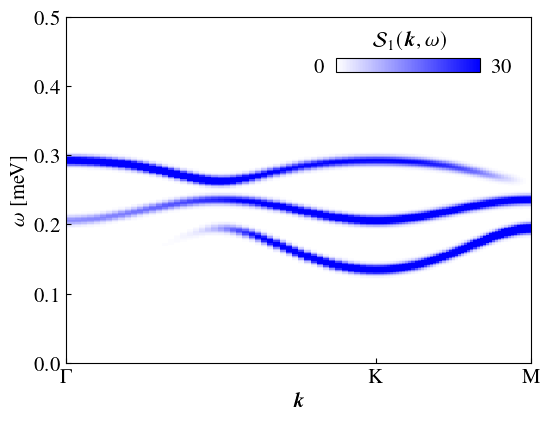

In [9]:
plt.rcParams['figure.figsize'] = (6, 4.5)
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['font.size'] = 15

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,newtxtext,newtxmath,bm}'
plt.rcParams['font.family'] = 'TeX Gyre Termes'

x = kc.len_list
axis_X, axis_Y = np.meshgrid(x, ω_list)
Intensity = (np.array(Sxx) + np.array(Syy) + np.array(Szz)).transpose()

fig, ax = plt.subplots()

cmap = colors.LinearSegmentedColormap.from_list("white_to_blue", [(1, 1, 1), (0, 0, 1)], N = 100)
imag = ax.pcolormesh(axis_X, axis_Y, Intensity, cmap = cmap, shading = "auto", vmin = 0, vmax = 30)

ax.set_xlim(x[0], x[-1])
ax.set_ylim(0.0, 0.5)
ax.set_xticks([x[0], xtic_K, x[-1]], [r"$\Gamma$", "K", "M"])
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
ax.set_xlabel(r"$\bm{k}$")
ax.set_ylabel(r"$\omega$ [meV]")
ax.tick_params(direction = 'in', color = 'black')

ax.text(4.15, 0.457, r'$\mathcal{S}_1(\bm{k},\omega)$', fontsize = 15)
ax.text(3.35, 0.42, r'$0$', fontsize = 15)
ax.text(5.75, 0.42, r'$30$', fontsize = 15)

cax  = ax.inset_axes((3.65, 0.42, 1.95, 0.02), transform = ax.transData)
cbar = fig.colorbar(imag, cax = cax, orientation = "horizontal")
cbar.set_ticks([0, 30])
cbar.set_ticklabels(['', ''])
cbar.ax.tick_params(length = 0)

plt.show()

## Compute 2-boson DOS $\mathcal{D}_2(\boldsymbol{k},\omega)$ (should only be used with a primitive super-lattice basis)

In [10]:
dos       = []
omega_min = []
omega_max = []

start = time.perf_counter()
for index_k in range(total_k):
    k = kc.k_list[index_k]
    if index_k % sptk.round2int(total_k / 50.0 + 1.0) == 0:
        print("*", end = "", flush = True)
    try:
        dos0, omega_min0, omega_max0 \
        = sptk.DOS_GLSW(model = hamiltonian,
                        k = k, omega_list = ω_list,
                        maxeval_2boson = 50000, maxeval_3boson = 0,
                        broadening = "Gaussian", sigma_or_eta = (0.01 / 2.35482) * unit.meV,
                        epsilon = 1.0e-5 * unit.meV)
        dos.append(dos0)
        omega_min.append(omega_min0)
        omega_max.append(omega_max0)
    except Exception as e:
        print(f"error: {e}, k = {k}")
print()
end = time.perf_counter()
print(f"Used {end - start:.6f}s")

**********************************
Used 816.985006s


## Plot 2-boson DOS $\mathcal{D}_2(\boldsymbol{k}, \omega)$

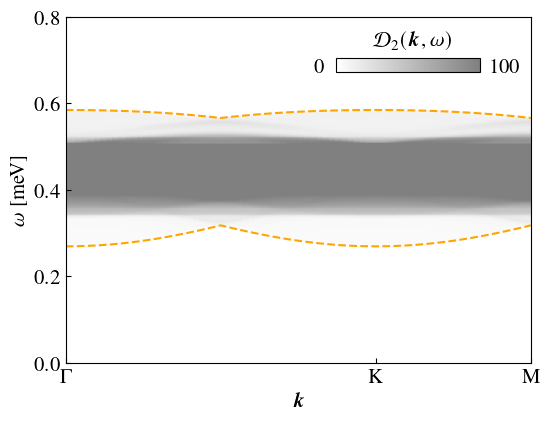

In [11]:
x = kc.len_list
axis_X, axis_Y = np.meshgrid(x, ω_list)

fig, ax = plt.subplots()

cmap = colors.LinearSegmentedColormap.from_list("white_to_gray", [(1, 1, 1), (0.5, 0.5, 0.5)], N = 100)
imag = ax.pcolormesh(axis_X, axis_Y, np.array(dos).transpose(), cmap = cmap, shading = "auto", vmin = 0, vmax = 100)
ax.plot(x, np.array(omega_min), '--', color = 'orange')
ax.plot(x, np.array(omega_max), '--', color = 'orange')

ax.set_xlim(x[0], x[-1])
ax.set_ylim(0.0, 0.8)
ax.set_xticks([x[0], xtic_K, x[-1]], [r"$\Gamma$", "K", "M"])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
ax.set_xlabel(r"$\bm{k}$")
ax.set_ylabel(r"$\omega$ [meV]")
ax.tick_params(direction = 'in', color = 'black')

ax.text(4.15, 0.731, r'$\mathcal{D}_2(\bm{k},\omega)$', fontsize = 15)
ax.text(3.35, 0.672, r'$0$', fontsize = 15)
ax.text(5.75, 0.672, r'$100$', fontsize = 15)

cax  = ax.inset_axes((3.65, 0.672, 1.95, 0.032), transform = ax.transData)
cbar = fig.colorbar(imag, cax = cax, orientation = "horizontal")
cbar.set_ticks([0, 100])
cbar.set_ticklabels(['', ''])
cbar.ax.tick_params(length = 0)

plt.show()

## Compute 2-boson DSSF $\mathcal{S}_2^{\mu\nu}(\boldsymbol{k},\omega)$

In [12]:
omega_k  = []
Sxx      = []
Syy      = []
Szz      = []
SxyPyx_R = []
SyzPzy_R = []
SzxPxz_R = []
SxyMyx_I = []
SyzMzy_I = []
SzxMxz_I = []

start = time.perf_counter()
for index_k in range(total_k):
    k = kc.k_list[index_k]
    if index_k % sptk.round2int(total_k / 50.0 + 1.0) == 0:
        print("*", end = "", flush = True)
    try:
        disp0, Sxx0, Syy0, Szz0, \
        SxyPyx_R0, SyzPzy_R0, SzxPxz_R0, \
        SxyMyx_I0, SyzMzy_I0, SzxMxz_I0 \
        = sptk.DSSF_GLSW(model = hamiltonian, T = 0.0,
                         k = k, omega_list = ω_list,
                         eval_1boson = False, maxeval_2boson = 50000,
                         maxeval_3boson = 0, maxeval_0boson = 0,
                         broadening = "Gaussian", sigma_or_eta = (0.01 / 2.35482) * unit.meV,
                         epsilon = 1.0e-5 * unit.meV)
        omega_k.append(disp0)
        Sxx.append(Sxx0)
        Syy.append(Syy0)
        Szz.append(Szz0)
        SxyPyx_R.append(SxyPyx_R0)
        SyzPzy_R.append(SyzPzy_R0)
        SzxPxz_R.append(SzxPxz_R0)
        SxyMyx_I.append(SxyMyx_I0)
        SyzMzy_I.append(SyzMzy_I0)
        SzxMxz_I.append(SzxMxz_I0)
    except Exception as e:
        print(f"error: {e}, k = {k}")
print()
end = time.perf_counter()
print(f"Used {end - start:.6f}s")

**********************************
Used 1104.359828s


## Plot 2-boson DSSF $\mathcal{S}_2(\boldsymbol{k}, \omega) \equiv \mathcal{S}_2^{xx}(\boldsymbol{k},\omega) + \mathcal{S}_2^{yy}(\boldsymbol{k},\omega) + \mathcal{S}_2^{zz}(\boldsymbol{k},\omega)$

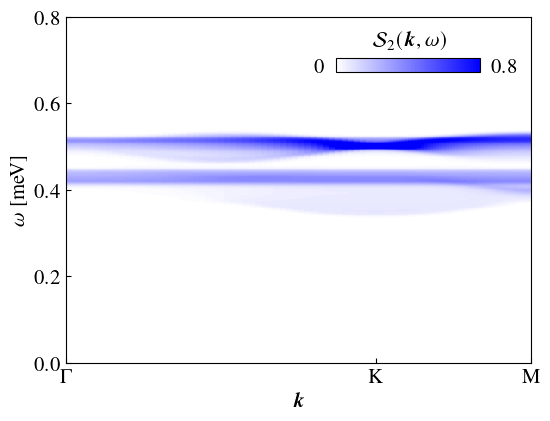

In [13]:
x = kc.len_list
axis_X, axis_Y = np.meshgrid(x, ω_list)
Intensity = (np.array(Sxx) + np.array(Syy) + np.array(Szz)).transpose()

fig, ax = plt.subplots()

cmap = colors.LinearSegmentedColormap.from_list("white_to_blue", [(1, 1, 1), (0, 0, 1)], N = 100)
imag = ax.pcolormesh(axis_X, axis_Y, Intensity, cmap = cmap, shading = "auto", vmin = 0, vmax = 0.8)
# uncomment the following line if you like to overplot the 1-magnon dispersion
# ax.plot(x, np.array(omega_k), 'r--')

ax.set_xlim(x[0], x[-1])
ax.set_ylim(0.0, 0.8)
ax.set_xticks([x[0], xtic_K, x[-1]], [r"$\Gamma$", "K", "M"])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
ax.set_xlabel(r"$\bm{k}$")
ax.set_ylabel(r"$\omega$ [meV]")
ax.tick_params(direction = 'in', color = 'black')

ax.text(4.15, 0.731, r'$\mathcal{S}_2(\bm{k},\omega)$', fontsize = 15)
ax.text(3.35, 0.672, r'$0$', fontsize = 15)
ax.text(5.75, 0.672, r'$0.8$', fontsize = 15)

cax  = ax.inset_axes((3.65, 0.672, 1.95, 0.032), transform = ax.transData)
cbar = fig.colorbar(imag, cax = cax, orientation = "horizontal")
cbar.set_ticks([0, 0.8])
cbar.set_ticklabels(['', ''])
cbar.ax.tick_params(length = 0)

plt.show()

## Compute 3-boson DOS $\mathcal{D}_3(\boldsymbol{k},\omega)$ (should only be used with a primitive super-lattice basis)
Since the 3-boson calculation is quite demanding to achieve high accuracy, in the following we will run it in parallel (the 2-boson part can be modified in the same way).

In this example, we fix the number of threads via the environment variable OMP_NUM_THREADS, which you can set before starting the jupyter notebook, e.g.,
```
export OMP_NUM_THREADS=4
```

**Warning**: Do not set OMP_NUM_THREADS to be more than your number of CPU cores!!!

In [14]:
def process_D3(index_k):
    k = kc.k_list[index_k]
    if index_k % sptk.round2int(total_k / 50.0 + 1.0) == 0:
        print("*", end = "", flush = True)
    try:
        return sptk.DOS_GLSW(model = hamiltonian,
                             k = k, omega_list = ω_list,
                             maxeval_2boson = 0, maxeval_3boson = 50000,
                             broadening = "Gaussian", sigma_or_eta = (0.01 / 2.35482) * unit.meV,
                             epsilon = 1.0e-5 * unit.meV)
    except Exception as e:
        print(f"error: {e}, k = {k}")

start = time.perf_counter()
results_D3 = Parallel(n_jobs = sptk.total_omp_threads(), prefer = "threads")(
    delayed(process_D3)(index_k) for index_k in range(total_k))
dos, omega_min, omega_max = zip(*results_D3)
print()
end = time.perf_counter()
print(f"Used {end - start:.6f}s")

**********************************
Used 1066.892584s


## Plot 3-boson DOS $\mathcal{D}_3(\boldsymbol{k}, \omega)$

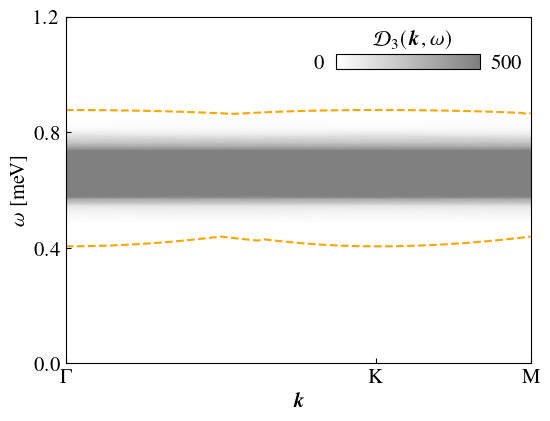

In [15]:
x = kc.len_list
axis_X, axis_Y = np.meshgrid(x, ω_list)

fig, ax = plt.subplots()

cmap = colors.LinearSegmentedColormap.from_list("white_to_gray", [(1, 1, 1), (0.5, 0.5, 0.5)], N = 100)
imag = ax.pcolormesh(axis_X, axis_Y, np.array(dos).transpose(), cmap = cmap, shading = "auto", vmin = 0, vmax = 500)
ax.plot(x, np.array(omega_min), '--', color = 'orange')
ax.plot(x, np.array(omega_max), '--', color = 'orange')

ax.set_xlim(x[0], x[-1])
ax.set_ylim(0.0, 1.2)
ax.set_xticks([x[0], xtic_K, x[-1]], [r"$\Gamma$", "K", "M"])
ax.set_yticks([0, 0.4, 0.8, 1.2])
ax.set_xlabel(r"$\bm{k}$")
ax.set_ylabel(r"$\omega$ [meV]")
ax.tick_params(direction = 'in', color = 'black')

ax.text(4.15, 1.1, r'$\mathcal{D}_3(\bm{k},\omega)$', fontsize = 15)
ax.text(3.35, 1.02, r'$0$', fontsize = 15)
ax.text(5.75, 1.02, r'$500$', fontsize = 15)

cax  = ax.inset_axes((3.65, 1.02, 1.95, 0.05), transform = ax.transData)
cbar = fig.colorbar(imag, cax = cax, orientation = "horizontal")
cbar.set_ticks([0, 500])
cbar.set_ticklabels(['', ''])
cbar.ax.tick_params(length = 0)

plt.show()

## Compute 3-boson DSSF $\mathcal{S}_3^{\mu\nu}(\boldsymbol{k},\omega)$

In [16]:
def process_S3(index_k):
    k = kc.k_list[index_k]
    if index_k % sptk.round2int(total_k / 50.0 + 1.0) == 0:
        print("*", end = "", flush = True)
    try:
        return sptk.DSSF_GLSW(model = hamiltonian, T = 0.0,
                              k = k, omega_list = ω_list,
                              eval_1boson = False, maxeval_2boson = 0,
                              maxeval_3boson = 50000, maxeval_0boson = 0,
                              broadening = "Gaussian", sigma_or_eta = (0.01 / 2.35482) * unit.meV,
                              epsilon = 1.0e-5 * unit.meV)
    except Exception as e:
        print(f"error: {e}, k = {k}")

start = time.perf_counter()
results_S3 = Parallel(n_jobs = sptk.total_omp_threads(), prefer = "threads")(
    delayed(process_S3)(index_k) for index_k in range(total_k))
omega_k, Sxx, Syy, Szz, \
SxyPyx_R, SyzPzy_R, SzxPxz_R, \
SxyMyx_I, SyzMzy_I, SzxMxz_I = zip(*results_S3)
print()
end = time.perf_counter()
print(f"Used {end - start:.6f}s")

**********************************
Used 1514.291880s


## Plot 3-boson DSSF $\mathcal{S}_3(\boldsymbol{k}, \omega) \equiv \mathcal{S}_3^{xx}(\boldsymbol{k},\omega) + \mathcal{S}_3^{yy}(\boldsymbol{k},\omega) + \mathcal{S}_3^{zz}(\boldsymbol{k},\omega)$

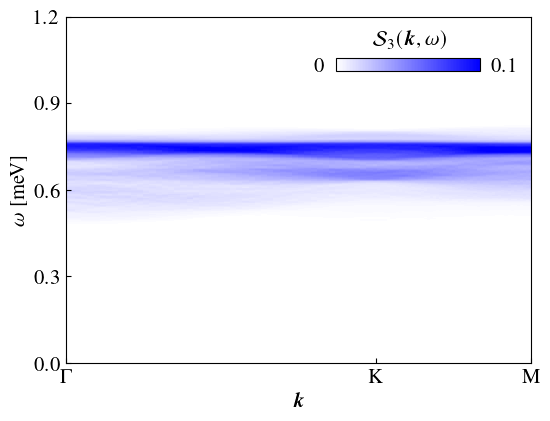

In [17]:
x = kc.len_list
axis_X, axis_Y = np.meshgrid(x, ω_list)
Intensity = (np.array(Sxx) + np.array(Syy) + np.array(Szz)).transpose()

fig, ax = plt.subplots()

cmap = colors.LinearSegmentedColormap.from_list("white_to_blue", [(1, 1, 1), (0, 0, 1)], N = 100)
imag = ax.pcolormesh(axis_X, axis_Y, Intensity, cmap = cmap, shading = "auto", vmin = 0, vmax = 0.1)
# uncomment the following line if you like to overplot the 1-magnon dispersion
# ax.plot(x, np.array(omega_k), 'r--')

ax.set_xlim(x[0], x[-1])
ax.set_ylim(0.0, 1.2)
ax.set_xticks([x[0], xtic_K, x[-1]], [r"$\Gamma$", "K", "M"])
ax.set_yticks([0, 0.3, 0.6, 0.9, 1.2])
ax.set_xlabel(r"$\bm{k}$")
ax.set_ylabel(r"$\omega$ [meV]")
ax.tick_params(direction = 'in', color = 'black')

ax.text(4.15, 1.10, r'$\mathcal{S}_3(\bm{k},\omega)$', fontsize = 15)
ax.text(3.35, 1.01, r'$0$', fontsize = 15)
ax.text(5.75, 1.01, r'$0.1$', fontsize = 15)

cax  = ax.inset_axes((3.65, 1.01, 1.95, 0.048), transform = ax.transData)
cbar = fig.colorbar(imag, cax = cax, orientation = "horizontal")
cbar.set_ticks([0, 0.1])
cbar.set_ticklabels(['', ''])
cbar.ax.tick_params(length = 0)

plt.show()